In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# CIFAR10 dataset
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 13069792.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [5]:
num_classes = 10
num_epochs = 5
batch_size = 16
learning_rate = 0.02
#Changed the hyperparameter

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.000, momentum = 0.9)
# The weight decay decides the L2 regularization here so If I set it to 0.00 then there will be no regularization and if it is 0.001 then the lambda of regularization is set to
# Some non zero value and I will plot for both regularized and unregularized
# Train the model
total_step = len(train_loader)

In [6]:
import gc
total_step = len(train_loader)
loss_values = []
accuracy_values = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        accuracy = 100 * correct / total
        accuracy_values.append(accuracy)
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, accuracy))



Epoch [1/5], Loss: 2.3960
Epoch [1/5], Loss: 2.5896
Epoch [1/5], Loss: 2.7682
Epoch [1/5], Loss: 2.5877
Epoch [1/5], Loss: 2.4591
Epoch [1/5], Loss: 3.0255
Epoch [1/5], Loss: 2.4836
Epoch [1/5], Loss: 2.5376
Epoch [1/5], Loss: 3.1063
Epoch [1/5], Loss: 2.5586
Epoch [1/5], Loss: 3.0190
Epoch [1/5], Loss: 2.8119
Epoch [1/5], Loss: 2.5597
Epoch [1/5], Loss: 2.9948
Epoch [1/5], Loss: 2.7420
Epoch [1/5], Loss: 2.4800
Epoch [1/5], Loss: 2.3786
Epoch [1/5], Loss: 2.3426
Epoch [1/5], Loss: 2.2448
Epoch [1/5], Loss: 2.3898
Epoch [1/5], Loss: 2.3806
Epoch [1/5], Loss: 2.3432
Epoch [1/5], Loss: 2.0509
Epoch [1/5], Loss: 2.2054
Epoch [1/5], Loss: 2.1556
Epoch [1/5], Loss: 1.7772
Epoch [1/5], Loss: 2.0765
Epoch [1/5], Loss: 2.0583
Epoch [1/5], Loss: 1.9442
Epoch [1/5], Loss: 2.2541
Epoch [1/5], Loss: 2.0036
Epoch [1/5], Loss: 2.2191
Epoch [1/5], Loss: 2.0169
Epoch [1/5], Loss: 2.4655
Epoch [1/5], Loss: 1.9071
Epoch [1/5], Loss: 2.0216
Epoch [1/5], Loss: 2.3519
Epoch [1/5], Loss: 2.1576
Epoch [1/5],

In [9]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 80.59 %


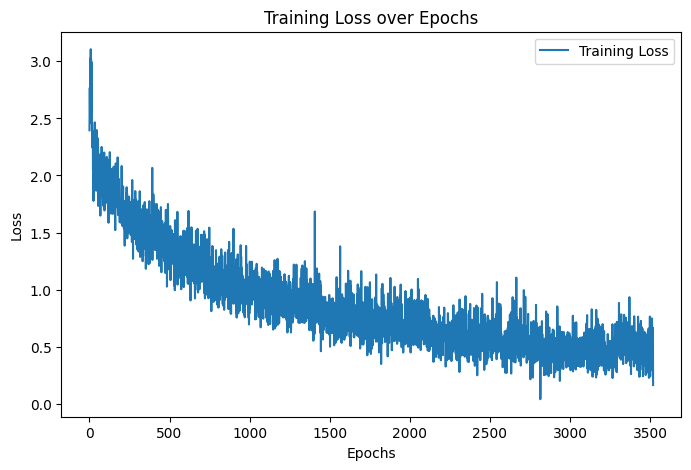

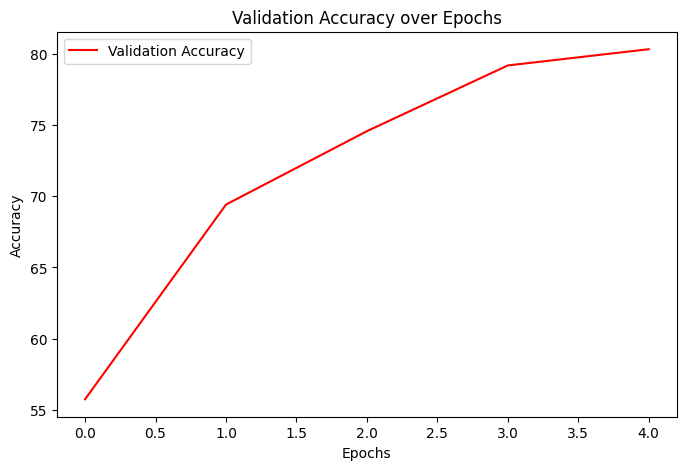

In [10]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(8, 5))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(8, 5))
plt.plot(accuracy_values, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

#This was when there was no regularization